In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data
data = pd.read_csv("pr_data_04252025.csv")

# Features (drop text and ID columns)
features = [
    "additions", "deletions", "changed_files", "comments", "commits",
    "author_account_age_days", "author_public_repos", "author_merged_prs",
    "has_milestone", "requested_reviewers_count", "title_length",
    "description_length", "pr_age_days"
]

X = data[features].copy()
y = data["merged"]

In [4]:
# Preprocessing
# Cap outliers at 95th percentile
for col in ["additions", "deletions", "changed_files", "comments", "commits",
            "author_merged_prs", "description_length", "pr_age_days",
            "author_public_repos", "requested_reviewers_count"]:
    cap = X[col].quantile(0.95)
    X[col] = X[col].clip(upper=cap)

In [6]:
# Clip negative values to 0 for log-transform
for col in ["pr_age_days"]:
    X[col] = X[col].clip(lower=0)

# Log-transform skewed features (add 1 to avoid log(0))
for col in ["additions", "deletions", "changed_files", "comments", "commits",
            "author_merged_prs", "description_length", "pr_age_days"]:
    X[col] = np.log1p(X[col])

In [7]:
# Create binary features for sparse columns
X["has_comments"] = (X["comments"] > 0).astype(int)
X["has_reviewers"] = (X["requested_reviewers_count"] > 0).astype(int)
X["has_pr_age"] = (X["pr_age_days"] > 0).astype(int)

In [8]:
# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Split data (80/20)
# Split data (80/20) and preserve indices
X_train, X_test, y_train, y_test, X_train_indices, X_test_indices = train_test_split(
    X_scaled, y, X.index, test_size=0.2, random_state=42
)

In [16]:
# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [17]:
# Predict and evaluate
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # Likelihood scores
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.95      0.85        43
        True       0.96      0.77      0.85        57

    accuracy                           0.85       100
   macro avg       0.86      0.86      0.85       100
weighted avg       0.87      0.85      0.85       100

ROC-AUC Score: 0.960220318237454


In [18]:
# Feature importance
importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": clf.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("\nFeature Importance:")
display(importance)


Feature Importance:


,Feature,Importance
7,author_merged_prs,0.204240
5,author_account_age_days,0.145570
12,pr_age_days,0.095483
11,description_length,0.078578
6,author_public_repos,0.077681
10,title_length,0.070362
0,additions,0.056050
4,commits,0.044189
1,deletions,0.043052
3,comments,0.037583


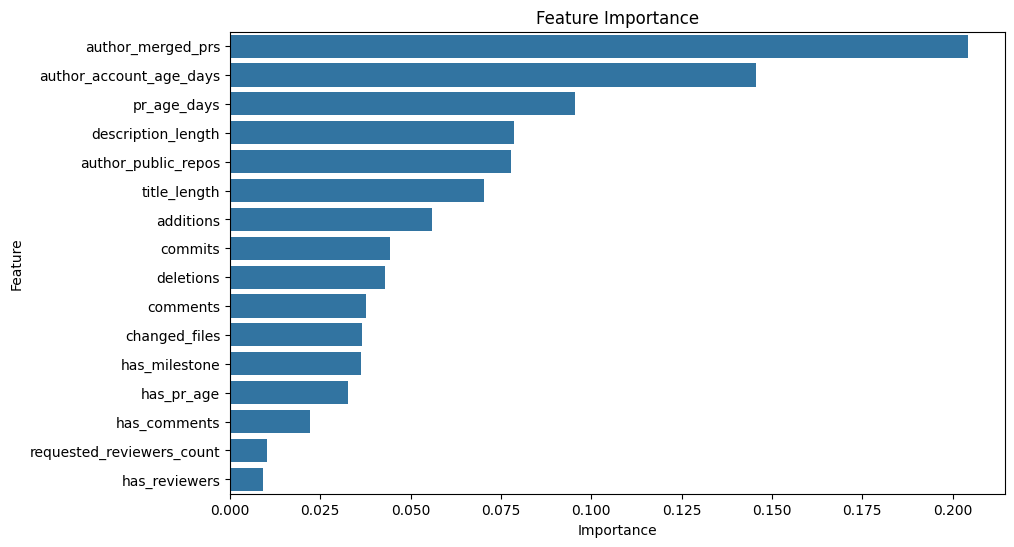

In [19]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance)
plt.title("Feature Importance")
plt.show()

In [22]:
# Example predictions with likelihood
results = pd.DataFrame({
    "Actual Merged": y_test.values,
    "Predicted Merged": y_pred,
    "Merge Likelihood": y_proba
})
print("\nSample Predictions:")
display(results.head())


Sample Predictions:


,Actual Merged,Predicted Merged,Merge Likelihood
0,False,False,0.12
1,True,True,1.00
2,True,True,0.85
3,True,True,0.54
4,True,True,0.77


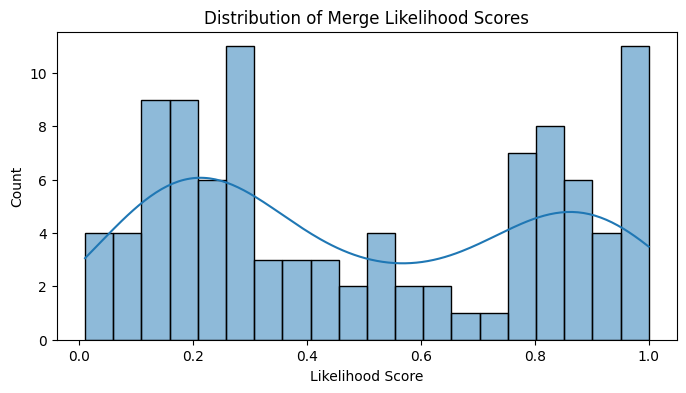

In [23]:
# Plot likelihood score distribution
plt.figure(figsize=(8, 4))
sns.histplot(y_proba, bins=20, kde=True)
plt.title("Distribution of Merge Likelihood Scores")
plt.xlabel("Likelihood Score")
plt.ylabel("Count")
plt.show()